In [2]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# For saving models
import joblib

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("="*60)
print("MODEL DEVELOPMENT NOTEBOOK")
print("="*60)
print("-> All libraries imported successfully!")
print(f"Current date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

MODEL DEVELOPMENT NOTEBOOK
-> All libraries imported successfully!
Current date: 2025-12-07 20:40:43


In [3]:
# load processed data
print("\n" + "="*60)
print("LOADING PROCESSED DATA")
print("="*60)

df = pd.read_csv('data/processed/tb_data_processed.csv')

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

print(f"-> Data loaded successfully!")
print(f"\nDataset info:")
print(f"  Shape: {df.shape}")
print(f"  Rows: {df.shape[0]:,}")
print(f"  Columns: {df.shape[1]}")
print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
print(f"  Districts: {df['district'].nunique()}")
print(f"  Missing values: {df.isnull().sum().sum()}")

# Display first few rows
print("\nFirst 3 rows:")
print(df.head(3))


LOADING PROCESSED DATA
-> Data loaded successfully!

Dataset info:
  Shape: (107877, 84)
  Rows: 107,877
  Columns: 84
  Date range: 2021-03-02 00:00:00 to 2024-12-31 00:00:00
  Districts: 77
  Missing values: 0

First 3 rows:
  district       date  aqi      co  humidity    nh3   no2     o3    pm10  \
0   Achham 2021-03-02  4.0  540.59     18.17  12.95  4.59  85.71   69.70   
1   Achham 2021-03-03  5.0  669.52     19.36  12.18  4.13  90.36  107.86   
2   Achham 2021-03-04  5.0  685.93     18.03  12.45  4.45  93.25  111.69   

    pm25  ...  avg_temp_roll_std_7  pm25_roll_std_7  humidity_roll_std_7  \
0  50.34  ...             1.163056        67.822932             3.997782   
1  90.65  ...             1.199484        31.954801             4.304310   
2  91.72  ...             1.201963        27.157193             4.704678   

   temp_humidity  pm25_humidity  temp_precipitation  temp_range  \
0       388.6563       914.6778                 0.0       15.47   
1       441.7952      1754.9

In [4]:
# define features and target variable
print("\n" + "="*60)
print("PREPARING FEATURES AND TARGET")
print("="*60)

# Columns to drop (non-predictive)
drop_cols = ['date', 'district']

# Target variable
target = 'tb_case'

# Feature columns (everything except date, district, and target)
feature_cols = [col for col in df.columns if col not in drop_cols + [target]]

# Separate features and target
X = df[feature_cols].copy()
y = df[target].copy()

print(f"-> Features and target prepared!")
print(f"\nFeature matrix (X):")
print(f"  Shape: {X.shape}")
print(f"  Number of features: {len(feature_cols)}")

print(f"\nTarget variable (y):")
print(f"  Shape: {y.shape}")
print(f"  Mean TB cases: {y.mean():.2f}")
print(f"  Min TB cases: {y.min()}")
print(f"  Max TB cases: {y.max()}")
print(f"  Std TB cases: {y.std():.2f}")

print(f"\nFeature names:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:3d}. {col}")


PREPARING FEATURES AND TARGET
-> Features and target prepared!

Feature matrix (X):
  Shape: (107877, 81)
  Number of features: 81

Target variable (y):
  Shape: (107877,)
  Mean TB cases: 2.04
  Min TB cases: 1.0
  Max TB cases: 66.0
  Std TB cases: 1.98

Feature names:
    1. aqi
    2. co
    3. humidity
    4. nh3
    5. no2
    6. o3
    7. pm10
    8. pm25
    9. precipitation
   10. air_pressure
   11. so2
   12. solar_radiation
   13. avg_temp
   14. temp_max
   15. temp_min
   16. wind_pressure
   17. wind_speed
   18. tb_lag_7
   19. tb_lag_14
   20. tb_lag_30
   21. tb_lag_60
   22. avg_temp_lag_7
   23. avg_temp_lag_14
   24. temp_max_lag_7
   25. temp_max_lag_14
   26. temp_min_lag_7
   27. temp_min_lag_14
   28. humidity_lag_7
   29. humidity_lag_14
   30. precipitation_lag_7
   31. precipitation_lag_14
   32. air_pressure_lag_7
   33. air_pressure_lag_14
   34. wind_speed_lag_7
   35. wind_speed_lag_14
   36. solar_radiation_lag_7
   37. solar_radiation_lag_14
   38. pm

In [5]:
# Final data quality check
print("\n" + "="*60)
print("DATA QUALITY CHECK")
print("="*60)

# Check for NaN in features
nan_features = X.isnull().sum()
if nan_features.sum() > 0:
    print("# WARNING: NaN values found in features:")
    print(nan_features[nan_features > 0])
else:
    print("-> No NaN values in features")

# Check for NaN in target
if y.isnull().sum() > 0:
    print(f"# WARNING: {y.isnull().sum()} NaN values in target")
else:
    print("-> No NaN values in target")

# Check for infinite values
inf_features = np.isinf(X).sum()
if inf_features.sum() > 0:
    print("# WARNING: Infinite values found in features")
else:
    print("-> No infinite values in features")

# Check data types
print(f"\nData types in features:")
print(X.dtypes.value_counts())

print("\n-> Data quality check complete!")


DATA QUALITY CHECK
-> No NaN values in features
-> No NaN values in target
-> No infinite values in features

Data types in features:
float64    81
Name: count, dtype: int64

-> Data quality check complete!


In [14]:
# applying VIF and removing the data:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully!")
print("✓ Ready for feature selection pipeline")

print("✓ All libraries imported successfully!")
print("✓ Ready for feature selection pipeline")

✓ All libraries imported successfully!
✓ Ready for feature selection pipeline
✓ All libraries imported successfully!
✓ Ready for feature selection pipeline


In [15]:
print("\n" + "="*60)
print("STEP 1: FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Train Random Forest to get feature importance
print("-> Training Random Forest for feature importance...")
rf_importance = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_importance.fit(X_train, y_train)

# Get feature importance
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_importance.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

print(f"-> Feature importance calculated!")
print(f"\nTop 30 Most Important Features:")
print(feature_importance_df.head(30).to_string(index=False))

# Cumulative importance
feature_importance_df['cumulative_importance'] = feature_importance_df['importance'].cumsum()
print(f"\nCumulative Importance Analysis:")
for threshold in [0.80, 0.90, 0.95, 0.99]:
    n_features = (feature_importance_df['cumulative_importance'] <= threshold).sum() + 1
    print(f"  {threshold*100:.0f}% of importance captured by top {n_features} features")



STEP 1: FEATURE IMPORTANCE ANALYSIS
-> Training Random Forest for feature importance...
-> Feature importance calculated!

Top 30 Most Important Features:
               feature  importance
        tb_case_roll_7    0.861722
       tb_case_roll_30    0.006606
              tb_lag_7    0.006206
             tb_lag_14    0.006106
       tb_case_roll_14    0.003561
            so2_lag_14    0.003426
   humidity_roll_std_7    0.003162
       solar_radiation    0.003102
      wind_speed_lag_7    0.002895
     wind_speed_lag_14    0.002878
       temp_min_lag_14    0.002772
              temp_min    0.002700
   air_pressure_lag_14    0.002684
    air_pressure_lag_7    0.002641
             o3_lag_14    0.002614
   avg_temp_roll_std_7    0.002590
          air_pressure    0.002581
        temp_max_lag_7    0.002528
 solar_radiation_lag_7    0.002372
solar_radiation_lag_14    0.002360
              o3_lag_7    0.002334
                    o3    0.002317
solar_radiation_roll_7    0.002267
    

✓ Feature importance plot saved to 'figures/01_feature_importance.png'


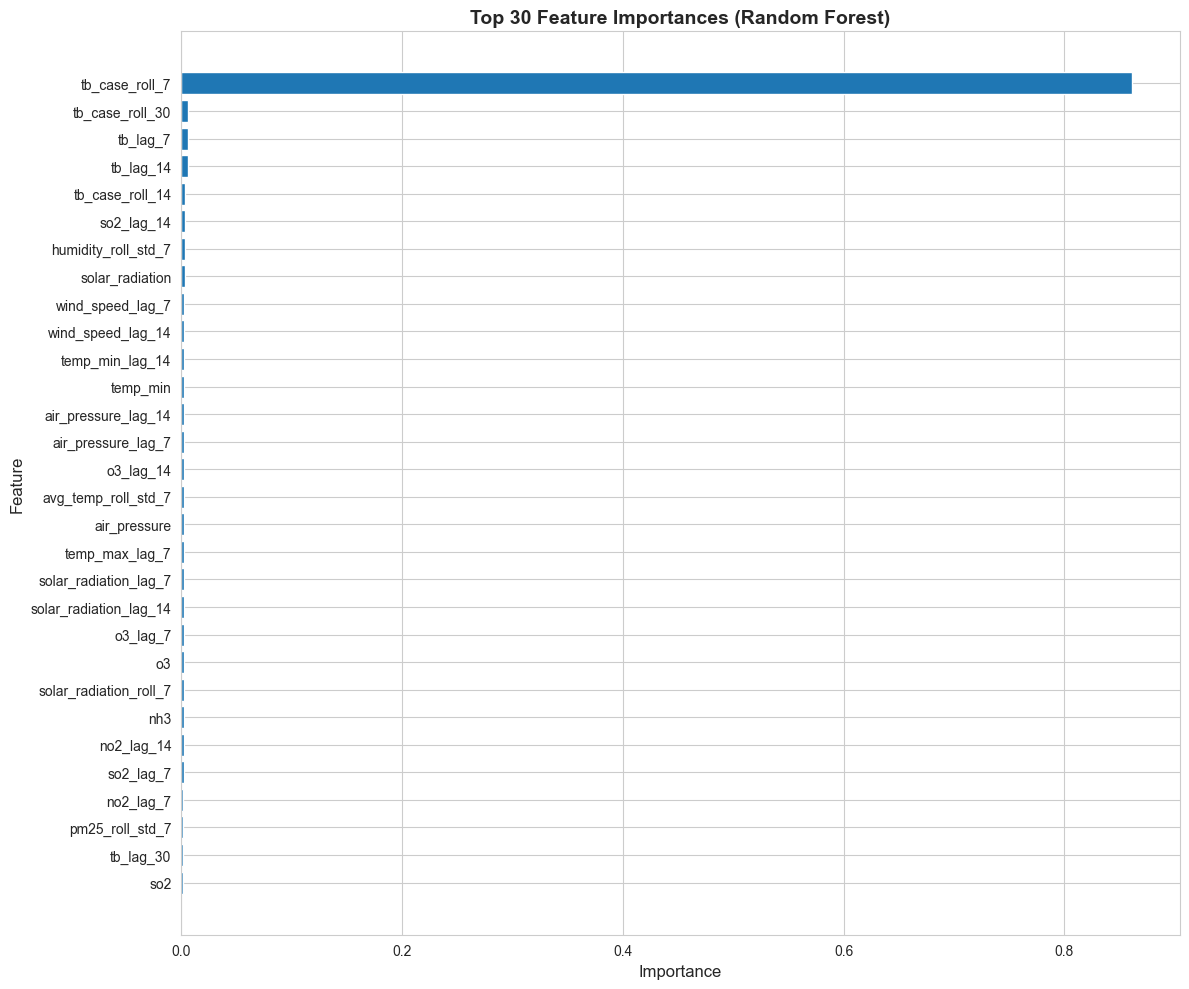


Cumulative Importance Analysis:
  80% of importance captured by top 1 features
  90% of importance captured by top 11 features
  95% of importance captured by top 33 features
  99% of importance captured by top 63 features

STEP 2: TIERED FEATURE SELECTION
-> Features categorized into tiers!

Tier 1 (Importance >= 1.0%):
  Count: 1
  Cumulative importance: 0.8617
  Features: ['tb_case_roll_7']...

Tier 2 (Importance >= 0.5% and < 1.0%):
  Count: 3
  Cumulative importance: 0.0189

Tier 3 (Importance < 0.5%):
  Count: 77
  Cumulative importance: 0.1194


In [16]:
plt.figure(figsize=(12, 10))
top_n = 30
plt.barh(range(top_n), feature_importance_df['importance'].head(top_n))
plt.yticks(range(top_n), feature_importance_df['feature'].head(top_n))
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 30 Feature Importances (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('figures/01_feature_importance.png', dpi=300, bbox_inches='tight')
print(f"✓ Feature importance plot saved to 'figures/01_feature_importance.png'")
plt.show()

# Cumulative importance
feature_importance_df['cumulative_importance'] = feature_importance_df['importance'].cumsum()
print(f"\nCumulative Importance Analysis:")
for threshold in [0.80, 0.90, 0.95, 0.99]:
    n_features = (feature_importance_df['cumulative_importance'] <= threshold).sum() + 1
    print(f"  {threshold*100:.0f}% of importance captured by top {n_features} features")


print("\n" + "="*60)
print("STEP 2: TIERED FEATURE SELECTION")
print("="*60)

# Define tiers based on importance
importance_threshold_tier1 = 0.01  # Features with >1% importance
importance_threshold_tier2 = 0.005  # Features with >0.5% importance

tier1_features = feature_importance_df[
    feature_importance_df['importance'] >= importance_threshold_tier1
]['feature'].tolist()

tier2_features = feature_importance_df[
    (feature_importance_df['importance'] >= importance_threshold_tier2) &
    (feature_importance_df['importance'] < importance_threshold_tier1)
]['feature'].tolist()

tier3_features = feature_importance_df[
    feature_importance_df['importance'] < importance_threshold_tier2
]['feature'].tolist()

print(f"-> Features categorized into tiers!")
print(f"\nTier 1 (Importance >= {importance_threshold_tier1*100}%):")
print(f"  Count: {len(tier1_features)}")
print(f"  Cumulative importance: {feature_importance_df[feature_importance_df['feature'].isin(tier1_features)]['importance'].sum():.4f}")
print(f"  Features: {tier1_features[:10]}...")

print(f"\nTier 2 (Importance >= {importance_threshold_tier2*100}% and < {importance_threshold_tier1*100}%):")
print(f"  Count: {len(tier2_features)}")
print(f"  Cumulative importance: {feature_importance_df[feature_importance_df['feature'].isin(tier2_features)]['importance'].sum():.4f}")

print(f"\nTier 3 (Importance < {importance_threshold_tier2*100}%):")
print(f"  Count: {len(tier3_features)}")
print(f"  Cumulative importance: {feature_importance_df[feature_importance_df['feature'].isin(tier3_features)]['importance'].sum():.4f}")

In [17]:
print("\n" + "="*60)
print("STEP 3: VIF CALCULATION (MULTICOLLINEARITY CHECK)")
print("="*60)

def calculate_vif(dataframe):
    """Calculate VIF for all features in dataframe"""
    vif_data = pd.DataFrame()
    vif_data["feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) 
                       for i in range(len(dataframe.columns))]
    return vif_data.sort_values('VIF', ascending=False).reset_index(drop=True)

# Start with Tier 1 + Tier 2 features
initial_features = tier1_features + tier2_features
X_train_vif = X_train[initial_features].copy()

print(f"-> Calculating VIF for {len(initial_features)} features (Tier 1 + Tier 2)...")
print("   This may take a moment...")

# Initial VIF calculation
vif_df = calculate_vif(X_train_vif)
print(f"\n-> Initial VIF calculated!")
print(f"\nTop 20 Features with Highest VIF:")
print(vif_df.head(20).to_string(index=False))

# Count high VIF features
high_vif_count = (vif_df['VIF'] > 10).sum()
very_high_vif_count = (vif_df['VIF'] > 100).sum()
print(f"\nVIF Summary:")
print(f"  Features with VIF > 10: {high_vif_count}")
print(f"  Features with VIF > 100: {very_high_vif_count}")



STEP 3: VIF CALCULATION (MULTICOLLINEARITY CHECK)
-> Calculating VIF for 4 features (Tier 1 + Tier 2)...
   This may take a moment...

-> Initial VIF calculated!

Top 20 Features with Highest VIF:
        feature       VIF
tb_case_roll_30 27.610039
 tb_case_roll_7 18.604673
      tb_lag_14  4.488822
       tb_lag_7  4.383267

VIF Summary:
  Features with VIF > 10: 2
  Features with VIF > 100: 0


In [18]:
print("\n" + "="*60)
print("STEP 4: ITERATIVE VIF REDUCTION")
print("="*60)

# Iteratively remove features with VIF > 10
vif_threshold = 10
selected_features = initial_features.copy()
iteration = 0
max_iterations = 50

print(f"-> Starting iterative VIF reduction (threshold = {vif_threshold})...")
print(f"   Initial features: {len(selected_features)}")

while iteration < max_iterations:
    X_temp = X_train[selected_features].copy()
    vif_df = calculate_vif(X_temp)
    
    max_vif = vif_df['VIF'].max()
    
    if max_vif <= vif_threshold:
        print(f"\n-> VIF reduction complete!")
        print(f"   All features now have VIF <= {vif_threshold}")
        break
    
    # Get feature with highest VIF
    worst_feature = vif_df.loc[vif_df['VIF'].idxmax(), 'feature']
    worst_vif = vif_df.loc[vif_df['VIF'].idxmax(), 'VIF']
    
    # Check importance before removing
    feature_imp = feature_importance_df[
        feature_importance_df['feature'] == worst_feature
    ]['importance'].values[0]
    
    # Remove the feature
    selected_features.remove(worst_feature)
    iteration += 1
    
    if iteration % 5 == 0:
        print(f"   Iteration {iteration}: Removed '{worst_feature}' (VIF={worst_vif:.2f}, Importance={feature_imp:.4f}), {len(selected_features)} features remaining")

if iteration >= max_iterations:
    print(f"\n   Warning: Reached maximum iterations ({max_iterations})")

print(f"\n-> Final feature count: {len(selected_features)}")
print(f"   Removed: {len(initial_features) - len(selected_features)} features")



STEP 4: ITERATIVE VIF REDUCTION
-> Starting iterative VIF reduction (threshold = 10)...
   Initial features: 4

-> VIF reduction complete!
   All features now have VIF <= 10

-> Final feature count: 3
   Removed: 1 features



Final VIF Statistics:
  Mean VIF: 4.22
  Max VIF: 5.34
  Features with VIF > 10: 0
  Features with VIF > 5: 1

Top 20 Features (Final VIF):
       feature      VIF
tb_case_roll_7 5.336631
      tb_lag_7 3.875544
     tb_lag_14 3.445372

STEP 5: FINAL FEATURE SET
-> Final selected features: 3

Feature Summary (Top 30):
       feature      VIF  importance
tb_case_roll_7 5.336631    0.861722
      tb_lag_7 3.875544    0.006206
     tb_lag_14 3.445372    0.006106

✓ Selected features saved to 'data/processed/selected_features.txt'
-> VIF distribution plot saved to 'figures/02_vif_distribution.png'


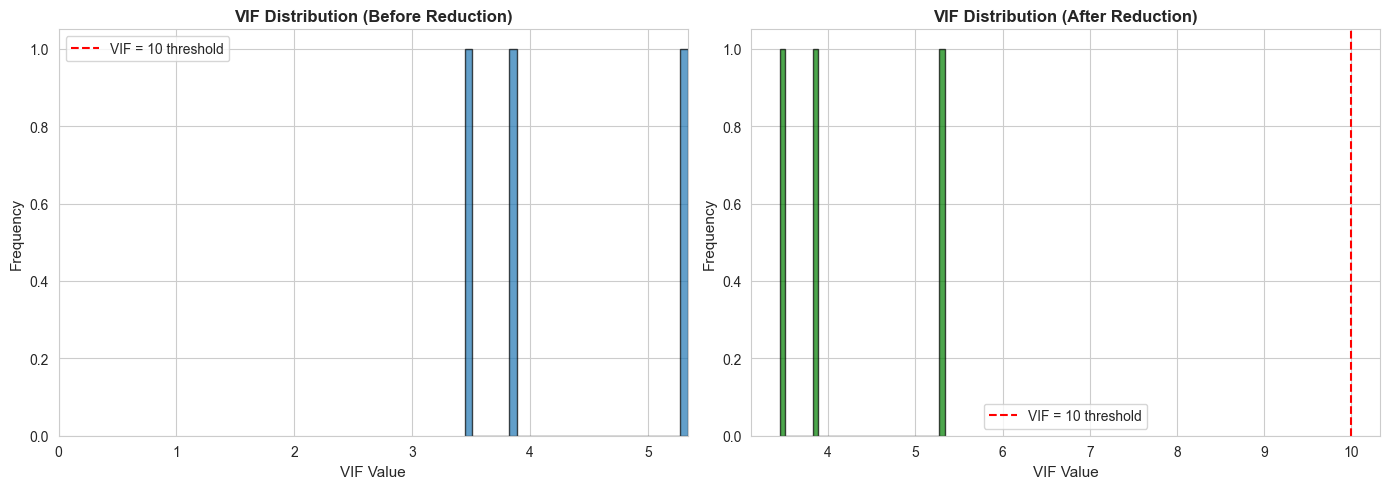

In [19]:
X_train_final = X_train[selected_features].copy()
final_vif_df = calculate_vif(X_train_final)

print(f"\nFinal VIF Statistics:")
print(f"  Mean VIF: {final_vif_df['VIF'].mean():.2f}")
print(f"  Max VIF: {final_vif_df['VIF'].max():.2f}")
print(f"  Features with VIF > 10: {(final_vif_df['VIF'] > 10).sum()}")
print(f"  Features with VIF > 5: {(final_vif_df['VIF'] > 5).sum()}")

print(f"\nTop 20 Features (Final VIF):")
print(final_vif_df.head(20).to_string(index=False))

print("\n" + "="*60)
print("STEP 5: FINAL FEATURE SET")
print("="*60)

# Merge with importance for final analysis
final_features_df = final_vif_df.merge(
    feature_importance_df[['feature', 'importance']], 
    on='feature'
).sort_values('importance', ascending=False)

print(f"-> Final selected features: {len(selected_features)}")
print(f"\nFeature Summary (Top 30):")
print(final_features_df.head(30).to_string(index=False))

# Save selected features
with open('data/processed/selected_features.txt', 'w') as f:
    for feature in selected_features:
        f.write(f"{feature}\n")
print(f"\n✓ Selected features saved to 'data/processed/selected_features.txt'")

# Plot VIF distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before VIF reduction (Tier 1+2)
axes[0].hist(vif_df['VIF'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(x=10, color='red', linestyle='--', label='VIF = 10 threshold')
axes[0].set_xlabel('VIF Value', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('VIF Distribution (Before Reduction)', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].set_xlim(0, min(vif_df['VIF'].max(), 200))

# After VIF reduction
axes[1].hist(final_vif_df['VIF'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1].axvline(x=10, color='red', linestyle='--', label='VIF = 10 threshold')
axes[1].set_xlabel('VIF Value', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('VIF Distribution (After Reduction)', fontsize=12, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.savefig('figures/02_vif_distribution.png', dpi=300, bbox_inches='tight')
print(f"-> VIF distribution plot saved to 'figures/02_vif_distribution.png'")
plt.show()


In [20]:
print("\n" + "="*60)
print("STEP 6: PREPARING DATASETS FOR MODEL COMPARISON")
print("="*60)

# Prepare datasets
X_train_original = X_train.copy()
X_test_original = X_test.copy()
X_train_selected = X_train[selected_features].copy()
X_test_selected = X_test[selected_features].copy()

# Scale features (required for SVR and BPNN)
print("-> Scaling features for SVR and BPNN...")
scaler_original = StandardScaler()
scaler_selected = StandardScaler()

X_train_original_scaled = scaler_original.fit_transform(X_train_original)
X_test_original_scaled = scaler_original.transform(X_test_original)

X_train_selected_scaled = scaler_selected.fit_transform(X_train_selected)
X_test_selected_scaled = scaler_selected.transform(X_test_selected)

print("-> Scaling complete!")
print(f"\nDataset shapes:")
print(f"  Original features: {X_train_original.shape[1]}")
print(f"  Selected features: {X_train_selected.shape[1]}")
print(f"  Reduction: {X_train_original.shape[1] - X_train_selected.shape[1]} features ({(1-X_train_selected.shape[1]/X_train_original.shape[1])*100:.1f}%)")

# Function to train and evaluate models
def train_and_evaluate(X_tr, X_te, y_tr, y_te, model_name, use_scaling=False):
    """Train model and return metrics"""
    
    if model_name == "Random Forest":
        model = RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        )
    elif model_name == "SVR":
        model = SVR(kernel='rbf', C=10, gamma='scale', epsilon=0.1)
    elif model_name == "BPNN":
        model = MLPRegressor(
            hidden_layer_sizes=(100, 50),
            activation='relu',
            solver='adam',
            max_iter=500,
            random_state=42,
            early_stopping=True,
            validation_fraction=0.1
        )
    
    # Train
    model.fit(X_tr, y_tr)
    
    # Predict
    y_pred = model.predict(X_te)
    
    # Metrics
    mae = mean_absolute_error(y_te, y_pred)
    rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    r2 = r2_score(y_te, y_pred)
    
    return {'MAE': mae, 'RMSE': rmse, 'R²': r2, 'predictions': y_pred}

# Train models with original features
print("\n" + "-"*60)
print("Training with ORIGINAL features ({} features)".format(len(feature_cols)))
print("-"*60)

results_original = {}

print("\n1. Random Forest (Original)...")
results_original['Random Forest'] = train_and_evaluate(
    X_train_original, X_test_original, y_train, y_test, "Random Forest"
)
print(f"   MAE: {results_original['Random Forest']['MAE']:.4f}")
print(f"   RMSE: {results_original['Random Forest']['RMSE']:.4f}")
print(f"   R²: {results_original['Random Forest']['R²']:.4f}")

print("\n2. SVR (Original)...")
results_original['SVR'] = train_and_evaluate(
    X_train_original_scaled, X_test_original_scaled, y_train, y_test, "SVR", use_scaling=True
)
print(f"   MAE: {results_original['SVR']['MAE']:.4f}")
print(f"   RMSE: {results_original['SVR']['RMSE']:.4f}")
print(f"   R²: {results_original['SVR']['R²']:.4f}")

print("\n3. BPNN (Original)...")
results_original['BPNN'] = train_and_evaluate(
    X_train_original_scaled, X_test_original_scaled, y_train, y_test, "BPNN", use_scaling=True
)
print(f"   MAE: {results_original['BPNN']['MAE']:.4f}")
print(f"   RMSE: {results_original['BPNN']['RMSE']:.4f}")
print(f"   R²: {results_original['BPNN']['R²']:.4f}")

# Train models with selected features
print("\n" + "-"*60)
print("Training with SELECTED features ({} features)".format(len(selected_features)))
print("-"*60)

results_selected = {}

print("\n1. Random Forest (Selected)...")
results_selected['Random Forest'] = train_and_evaluate(
    X_train_selected, X_test_selected, y_train, y_test, "Random Forest"
)
print(f"   MAE: {results_selected['Random Forest']['MAE']:.4f}")
print(f"   RMSE: {results_selected['Random Forest']['RMSE']:.4f}")
print(f"   R²: {results_selected['Random Forest']['R²']:.4f}")

print("\n2. SVR (Selected)...")
results_selected['SVR'] = train_and_evaluate(
    X_train_selected_scaled, X_test_selected_scaled, y_train, y_test, "SVR", use_scaling=True
)
print(f"   MAE: {results_selected['SVR']['MAE']:.4f}")
print(f"   RMSE: {results_selected['SVR']['RMSE']:.4f}")
print(f"   R²: {results_selected['SVR']['R²']:.4f}")

print("\n3. BPNN (Selected)...")
results_selected['BPNN'] = train_and_evaluate(
    X_train_selected_scaled, X_test_selected_scaled, y_train, y_test, "BPNN", use_scaling=True
)
print(f"   MAE: {results_selected['BPNN']['MAE']:.4f}")
print(f"   RMSE: {results_selected['BPNN']['RMSE']:.4f}")
print(f"   R²: {results_selected['BPNN']['R²']:.4f}")


print("\n" + "="*60)
print("STEP 7: PERFORMANCE COMPARISON")
print("="*60)

# Create comparison dataframe
comparison_data = []
for model_name in ['Random Forest', 'SVR', 'BPNN']:
    for metric in ['MAE', 'RMSE', 'R²']:
        comparison_data.append({
            'Model': model_name,
            'Metric': metric,
            'Original': results_original[model_name][metric],
            'Selected': results_selected[model_name][metric],
            'Improvement': results_selected[model_name][metric] - results_original[model_name][metric]
        })

comparison_df = pd.DataFrame(comparison_data)

# For R², positive improvement is good. For MAE/RMSE, negative improvement is good
comparison_df['Improvement_Display'] = comparison_df.apply(
    lambda row: row['Improvement'] if row['Metric'] == 'R²' else -row['Improvement'], 
    axis=1
)

print("\nDetailed Comparison:")
print(comparison_df[['Model', 'Metric', 'Original', 'Selected', 'Improvement']].to_string(index=False))



STEP 6: PREPARING DATASETS FOR MODEL COMPARISON
-> Scaling features for SVR and BPNN...
-> Scaling complete!

Dataset shapes:
  Original features: 81
  Selected features: 3
  Reduction: 78 features (96.3%)

------------------------------------------------------------
Training with ORIGINAL features (81 features)
------------------------------------------------------------

1. Random Forest (Original)...
   MAE: 0.7615
   RMSE: 1.4470
   R²: 0.5746

2. SVR (Original)...
   MAE: 0.8341
   RMSE: 1.5460
   R²: 0.5144

3. BPNN (Original)...
   MAE: 0.8453
   RMSE: 1.5018
   R²: 0.5418

------------------------------------------------------------
Training with SELECTED features (3 features)
------------------------------------------------------------

1. Random Forest (Selected)...
   MAE: 0.7579
   RMSE: 1.4468
   R²: 0.5747

2. SVR (Selected)...
   MAE: 0.7818
   RMSE: 1.4616
   R²: 0.5660

3. BPNN (Selected)...
   MAE: 0.7770
   RMSE: 1.4376
   R²: 0.5802

STEP 7: PERFORMANCE COMPARISON


In [8]:
# Split data into training and testing sets
print("\n" + "="*60)
print("SPLITTING DATA (TEMPORAL SPLIT)")
print("="*60)

# For time series, we use temporal split (not random split)
# Sort by date to ensure proper temporal ordering
df_sorted = df.sort_values('date').reset_index(drop=True)

# Get sorted features and target
X_sorted = df_sorted[feature_cols]
y_sorted = df_sorted[target]
dates_sorted = df_sorted['date']

# 80-20 split
split_index = int(len(df_sorted) * 0.8)

# Split features and target
X_train = X_sorted.iloc[:split_index].copy()
X_test = X_sorted.iloc[split_index:].copy()
y_train = y_sorted.iloc[:split_index].copy()
y_test = y_sorted.iloc[split_index:].copy()

# Split dates for reference
train_dates = dates_sorted.iloc[:split_index]
test_dates = dates_sorted.iloc[split_index:]

print("-> Data split complete!")
print(f"\nTraining set:")
print(f"  Samples: {X_train.shape[0]:,} ({X_train.shape[0]/len(df_sorted)*100:.1f}%)")
print(f"  Date range: {train_dates.min()} to {train_dates.max()}")
print(f"  TB cases - Mean: {y_train.mean():.2f}, Min: {y_train.min()}, Max: {y_train.max()}")

print(f"\nTesting set:")
print(f"  Samples: {X_test.shape[0]:,} ({X_test.shape[0]/len(df_sorted)*100:.1f}%)")
print(f"  Date range: {test_dates.min()} to {test_dates.max()}")
print(f"  TB cases - Mean: {y_test.mean():.2f}, Min: {y_test.min()}, Max: {y_test.max()}")

print(f"\nFeature dimensions:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  y_test: {y_test.shape}")


SPLITTING DATA (TEMPORAL SPLIT)
-> Data split complete!

Training set:
  Samples: 86,301 (80.0%)
  Date range: 2021-03-02 00:00:00 to 2024-03-26 00:00:00
  TB cases - Mean: 1.99, Min: 1.0, Max: 48.0

Testing set:
  Samples: 21,576 (20.0%)
  Date range: 2024-03-26 00:00:00 to 2024-12-31 00:00:00
  TB cases - Mean: 2.22, Min: 1.0, Max: 66.0

Feature dimensions:
  X_train: (86301, 81)
  X_test: (21576, 81)
  y_train: (86301,)
  y_test: (21576,)


In [9]:
# Scale features (CRITICAL for SVR and Neural Networks)
print("\n" + "="*60)
print("FEATURE SCALING")
print("="*60)

# Initialize scaler
scaler = StandardScaler()

# Fit on training data and transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

print("-> Feature scaling complete!")
print(f"\nScaling statistics (training data):")
print(f"  Original data:")
print(f"    Mean range: [{X_train.mean().min():.2f}, {X_train.mean().max():.2f}]")
print(f"    Std range: [{X_train.std().min():.2f}, {X_train.std().max():.2f}]")
print(f"\n  Scaled data:")
print(f"    Mean: {X_train_scaled.mean():.6f} (should be ~0)")
print(f"    Std: {X_train_scaled.std():.6f} (should be ~1)")

print("\n Note: Random Forest doesn't require scaling, but SVR and Neural Networks do!")


FEATURE SCALING
-> Feature scaling complete!

Scaling statistics (training data):
  Original data:
    Mean range: [0.88, 3226.75]
    Std range: [0.48, 4404.66]

  Scaled data:
    Mean: 0.000000 (should be ~0)
    Std: 1.000000 (should be ~1)

 Note: Random Forest doesn't require scaling, but SVR and Neural Networks do!



VISUALIZING TRAIN-TEST SPLIT


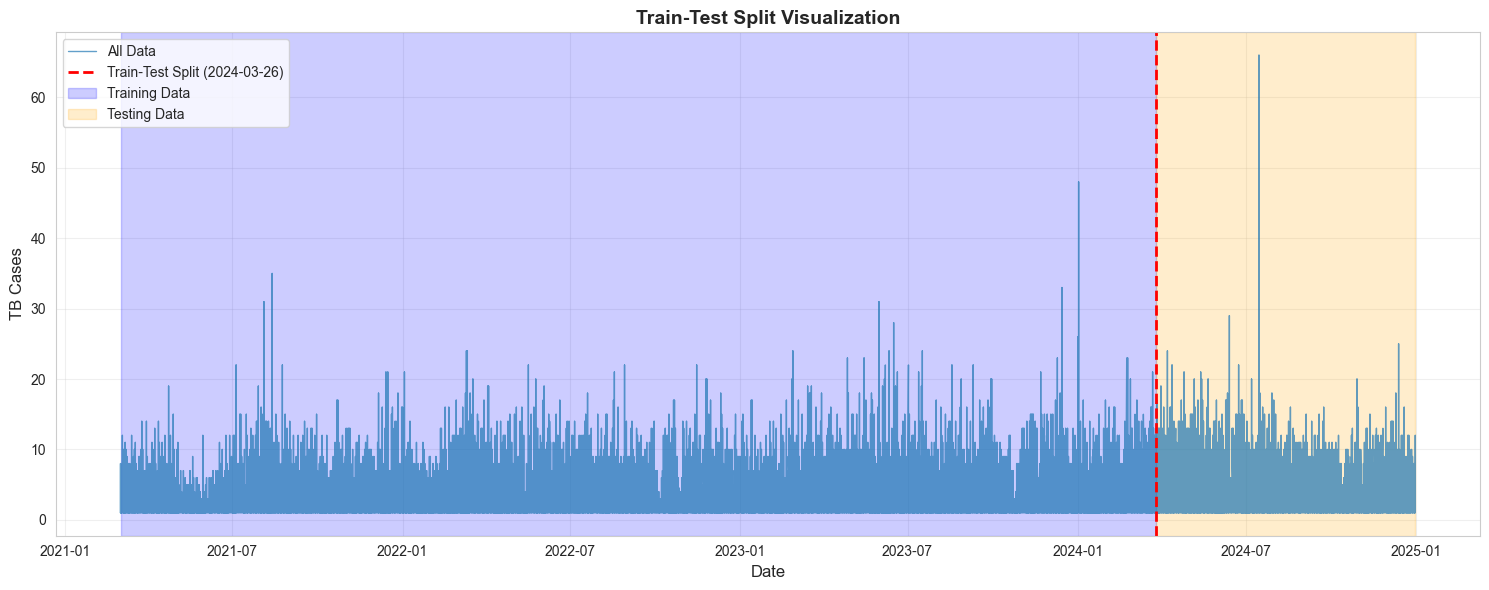

-> Visualization saved to 'figures/train_test_split.png'


In [10]:
# Visualize the train-test split
print("\n" + "="*60)
print("VISUALIZING TRAIN-TEST SPLIT")
print("="*60)

plt.figure(figsize=(15, 6))

# Create a full timeline
full_dates = dates_sorted.values
full_tb = y_sorted.values

# Plot
plt.plot(full_dates, full_tb, linewidth=1, alpha=0.7, label='All Data')
plt.axvline(x=train_dates.iloc[-1], color='red', linestyle='--', linewidth=2, 
            label=f'Train-Test Split ({train_dates.iloc[-1].strftime("%Y-%m-%d")})')

# Shade regions
plt.axvspan(train_dates.min(), train_dates.max(), alpha=0.2, color='blue', label='Training Data')
plt.axvspan(test_dates.min(), test_dates.max(), alpha=0.2, color='orange', label='Testing Data')

plt.title('Train-Test Split Visualization', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('TB Cases', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/train_test_split.png', dpi=300, bbox_inches='tight')
plt.show()

print("-> Visualization saved to 'figures/train_test_split.png'")

In [11]:
# RANDOM FOREST MODEL
# Train Random Forest Regression
print("\n" + "="*70)
print("MODEL 1: RANDOM FOREST REGRESSION")
print("="*70)

# Initialize Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=200,        # Number of trees
    max_depth=20,            # Maximum depth of trees
    min_samples_split=5,     # Minimum samples to split a node
    min_samples_leaf=2,      # Minimum samples in leaf node
    max_features='sqrt',     # Number of features to consider for best split
    random_state=42,
    n_jobs=-1,               # Use all CPU cores
    verbose=0                # No progress output
)

print("Model configuration:")
print(f"  n_estimators: {rf_model.n_estimators}")
print(f"  max_depth: {rf_model.max_depth}")
print(f"  min_samples_split: {rf_model.min_samples_split}")
print(f"  min_samples_leaf: {rf_model.min_samples_leaf}")
print(f"  max_features: {rf_model.max_features}")

# Train model (Random Forest doesn't need scaled data)
print("\n... Training Random Forest model...")
import time
start_time = time.time()

rf_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"-> Training complete! Time taken: {training_time:.2f} seconds")

# Make predictions
print("\n... Making predictions...")
y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_test = rf_model.predict(X_test)

print("-> Predictions complete!")
print(f"  Training predictions: {y_pred_rf_train.shape}")
print(f"  Testing predictions: {y_pred_rf_test.shape}")
print(f"\nSample predictions (first 5):")
print(f"  Actual:    {y_test.iloc[:5].values}")
print(f"  Predicted: {y_pred_rf_test[:5]}")


MODEL 1: RANDOM FOREST REGRESSION
Model configuration:
  n_estimators: 200
  max_depth: 20
  min_samples_split: 5
  min_samples_leaf: 2
  max_features: sqrt

... Training Random Forest model...
-> Training complete! Time taken: 16.45 seconds

... Making predictions...
-> Predictions complete!
  Training predictions: (86301,)
  Testing predictions: (21576,)

Sample predictions (first 5):
  Actual:    [5. 1. 1. 1. 1.]
  Predicted: [2.40132447 1.0000428  1.01450807 6.31325542 1.00180129]



RANDOM FOREST - FEATURE IMPORTANCE
Top 20 Most Important Features:
            feature  importance
     tb_case_roll_7    0.179324
    tb_case_roll_14    0.124714
    tb_case_roll_30    0.116335
          tb_lag_14    0.040692
           tb_lag_7    0.037118
       air_pressure    0.026759
 air_pressure_lag_7    0.026010
air_pressure_lag_14    0.023973
          tb_lag_30    0.018679
          tb_lag_60    0.017184
                so2    0.012902
         so2_lag_14    0.011859
          so2_lag_7    0.010251
         no2_lag_14    0.009412
          temp_pm25    0.008352
           co_lag_7    0.007935
   avg_temp_roll_30    0.007360
    avg_temp_roll_7    0.007182
          no2_lag_7    0.006946
                no2    0.006883


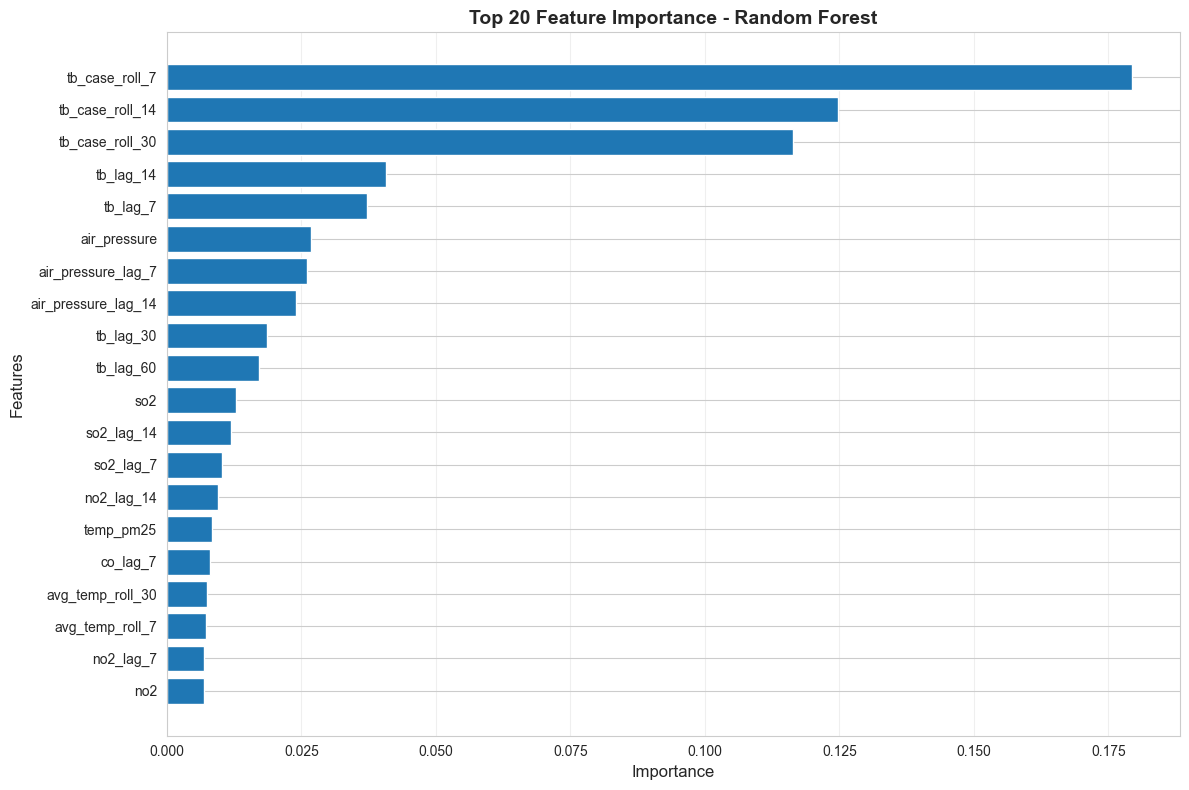


-> Feature importance plot saved to 'figures/feature_importance_rf.png'
-> Feature importance saved to 'data/results/feature_importance_rf.csv'


In [12]:
# Analyze Random Forest feature importance
print("\n" + "="*60)
print("RANDOM FOREST - FEATURE IMPORTANCE")
print("="*60)

# Get feature importance
feature_importance_rf = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(feature_importance_rf.head(20).to_string(index=False))

# Visualize top 20 features
plt.figure(figsize=(12, 8))
top_20 = feature_importance_rf.head(20)
plt.barh(range(len(top_20)), top_20['importance'].values)
plt.yticks(range(len(top_20)), top_20['feature'].values)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 20 Feature Importance - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('figures/feature_importance_rf.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n-> Feature importance plot saved to 'figures/feature_importance_rf.png'")

# Save feature importance to CSV
feature_importance_rf.to_csv('data/results/feature_importance_rf.csv', index=False)
print("-> Feature importance saved to 'data/results/feature_importance_rf.csv'")

In [15]:
# SVR MODEL
# Train Support Vector Regression
print("\n" + "="*70)
print("MODEL 2: SUPPORT VECTOR REGRESSION (SVR)")
print("="*70)

# Initialize SVR model
svr_model = SVR(
    kernel='rbf',           # Radial basis function kernel
    C=10,                   # Regularization parameter
    epsilon=0.1,            # Epsilon in epsilon-SVR model
    gamma='scale',          # Kernel coefficient
    cache_size=1000,        # Cache size in MB
    verbose=False
)

print("Model configuration:")
print(f"  kernel: {svr_model.kernel}")
print(f"  C: {svr_model.C}")
print(f"  epsilon: {svr_model.epsilon}")
print(f"  gamma: {svr_model.gamma}")

# Train model (SVR NEEDS scaled data!)
print("\n... Training SVR model...")
print("   (This may take a while for large datasets...)")
start_time = time.time()

svr_model.fit(X_train_scaled, y_train)

training_time = time.time() - start_time
print(f"-> Training complete! Time taken: {training_time:.2f} seconds")

# Make predictions
print("\n... Making predictions...")
y_pred_svr_train = svr_model.predict(X_train_scaled)
y_pred_svr_test = svr_model.predict(X_test_scaled)

print("-> Predictions complete!")
print(f"  Training predictions: {y_pred_svr_train.shape}")
print(f"  Testing predictions: {y_pred_svr_test.shape}")
print(f"\nSample predictions (first 5):")
print(f"  Actual:    {y_test.iloc[:5].values}")
print(f"  Predicted: {y_pred_svr_test[:5]}")

print(f"\nNumber of support vectors: {len(svr_model.support_)}")


MODEL 2: SUPPORT VECTOR REGRESSION (SVR)
Model configuration:
  kernel: rbf
  C: 10
  epsilon: 0.1
  gamma: scale

... Training SVR model...
   (This may take a while for large datasets...)
-> Training complete! Time taken: 3613.73 seconds

... Making predictions...
-> Predictions complete!
  Training predictions: (86301,)
  Testing predictions: (21576,)

Sample predictions (first 5):
  Actual:    [5. 1. 1. 1. 1.]
  Predicted: [2.29432668 0.97911856 0.87673757 6.57362957 1.03517312]

Number of support vectors: 56563


In [16]:
# Cell 11: Train Backpropagation Neural Network
print("\n" + "="*70)
print("MODEL 3: BACKPROPAGATION NEURAL NETWORK (MLP)")
print("="*70)

# Initialize BP Neural Network (Multi-Layer Perceptron)
bp_model = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),  # 3 hidden layers
    activation='relu',                  # ReLU activation function
    solver='adam',                      # Adam optimizer
    learning_rate='adaptive',           # Adaptive learning rate
    learning_rate_init=0.001,          # Initial learning rate
    max_iter=500,                       # Maximum epochs
    batch_size='auto',                  # Batch size
    random_state=42,
    early_stopping=True,                # Stop if no improvement
    validation_fraction=0.1,            # 10% for validation
    n_iter_no_change=20,               # Patience
    verbose=True                        # Show progress
)

print("Model configuration:")
print(f"  hidden_layer_sizes: {bp_model.hidden_layer_sizes}")
print(f"  activation: {bp_model.activation}")
print(f"  solver: {bp_model.solver}")
print(f"  learning_rate_init: {bp_model.learning_rate_init}")
print(f"  max_iter: {bp_model.max_iter}")
print(f"  early_stopping: {bp_model.early_stopping}")

# Train model (Neural Network NEEDS scaled data!)
print("\n... Training BP Neural Network...")
print("   (Progress will be shown below...)\n")
start_time = time.time()

bp_model.fit(X_train_scaled, y_train)

training_time = time.time() - start_time
print(f"\n-> Training complete! Time taken: {training_time:.2f} seconds")
print(f"   Number of iterations: {bp_model.n_iter_}")
print(f"   Final training loss: {bp_model.loss_:.6f}")

# Make predictions
print("\n... Making predictions...")
y_pred_bp_train = bp_model.predict(X_train_scaled)
y_pred_bp_test = bp_model.predict(X_test_scaled)

print("-> Predictions complete!")
print(f"  Training predictions: {y_pred_bp_train.shape}")
print(f"  Testing predictions: {y_pred_bp_test.shape}")
print(f"\nSample predictions (first 5):")
print(f"  Actual:    {y_test.iloc[:5].values}")
print(f"  Predicted: {y_pred_bp_test[:5]}")


MODEL 3: BACKPROPAGATION NEURAL NETWORK (MLP)
Model configuration:
  hidden_layer_sizes: (128, 64, 32)
  activation: relu
  solver: adam
  learning_rate_init: 0.001
  max_iter: 500
  early_stopping: True

... Training BP Neural Network...
   (Progress will be shown below...)

Iteration 1, loss = 0.90246796
Validation score: 0.550191
Iteration 2, loss = 0.79543619
Validation score: 0.562752
Iteration 3, loss = 0.77886131
Validation score: 0.562951
Iteration 4, loss = 0.77180358
Validation score: 0.560412
Iteration 5, loss = 0.76583462
Validation score: 0.575597
Iteration 6, loss = 0.75476965
Validation score: 0.568127
Iteration 7, loss = 0.75318801
Validation score: 0.581719
Iteration 8, loss = 0.75128380
Validation score: 0.570977
Iteration 9, loss = 0.74562903
Validation score: 0.577137
Iteration 10, loss = 0.73818352
Validation score: 0.581747
Iteration 11, loss = 0.73353094
Validation score: 0.577670
Iteration 12, loss = 0.72776881
Validation score: 0.570392
Iteration 13, loss = 0.

In [17]:
# Save all trained models
print("\n" + "="*60)
print("SAVING TRAINED MODELS")
print("="*60)

# Create models directory if it doesn't exist
import os
os.makedirs('models', exist_ok=True)

# Save models
joblib.dump(rf_model, 'models/random_forest_model.pkl')
print("-> Random Forest model saved: 'models/random_forest_model.pkl'")

joblib.dump(svr_model, 'models/svr_model.pkl')
print("-> SVR model saved: 'models/svr_model.pkl'")

joblib.dump(bp_model, 'models/bp_neural_network_model.pkl')
print("-> BP Neural Network model saved: 'models/bp_neural_network_model.pkl'")

joblib.dump(scaler, 'models/scaler.pkl')
print("-> Scaler saved: 'models/scaler.pkl'")

print("\n" + "="*60)
print("ALL MODELS SAVED SUCCESSFULLY!")
print("="*60)


SAVING TRAINED MODELS
-> Random Forest model saved: 'models/random_forest_model.pkl'
-> SVR model saved: 'models/svr_model.pkl'
-> BP Neural Network model saved: 'models/bp_neural_network_model.pkl'
-> Scaler saved: 'models/scaler.pkl'

ALL MODELS SAVED SUCCESSFULLY!


In [18]:
# Save predictions for evaluation
print("\n" + "="*60)
print("SAVING PREDICTIONS")
print("="*60)

# Create results directory
os.makedirs('data/results', exist_ok=True)

# Create predictions DataFrame
predictions_df = pd.DataFrame({
    'date': test_dates.values,
    'actual': y_test.values,
    'rf_predicted': y_pred_rf_test,
    'svr_predicted': y_pred_svr_test,
    'bp_predicted': y_pred_bp_test
})

# Save to CSV
predictions_df.to_csv('data/results/model_predictions.csv', index=False)
print("✅ Predictions saved to 'data/results/model_predictions.csv'")

print(f"\nPredictions summary:")
print(predictions_df.head(10))


SAVING PREDICTIONS
✅ Predictions saved to 'data/results/model_predictions.csv'

Predictions summary:
        date  actual  rf_predicted  svr_predicted  bp_predicted
0 2024-03-26     5.0      2.576790       2.294327      2.491180
1 2024-03-26     1.0      1.000042       0.979119      0.968684
2 2024-03-26     1.0      1.010469       0.876738      0.910240
3 2024-03-26     1.0      6.280061       6.573630      6.916727
4 2024-03-26     1.0      1.000723       1.035173      0.958035
5 2024-03-26     3.0      2.322241       2.225726      1.476724
6 2024-03-26     3.0      1.946722       2.199609      2.130030
7 2024-03-26     1.0      4.772112       2.472225      4.137951
8 2024-03-26     1.0      1.769827       1.743889      1.669422
9 2024-03-26     2.0      1.511028       1.158158      1.495987


In [19]:
# Quick performance preview (detailed evaluation in next notebook)
print("\n" + "="*70)
print("QUICK PERFORMANCE PREVIEW")
print("="*70)

def quick_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name}:")
    print(f"  MAE:  {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²:   {r2:.4f}")

print("Testing Set Performance:")
quick_metrics(y_test, y_pred_rf_test, "Random Forest")
quick_metrics(y_test, y_pred_svr_test, "SVR")
quick_metrics(y_test, y_pred_bp_test, "BP Neural Network")

print("\n" + "="*70)



QUICK PERFORMANCE PREVIEW
Testing Set Performance:

Random Forest:
  MAE:  0.7923
  RMSE: 1.4645
  R²:   0.5643

SVR:
  MAE:  0.8257
  RMSE: 1.5374
  R²:   0.5199

BP Neural Network:
  MAE:  0.8212
  RMSE: 1.4702
  R²:   0.5609

